<a href="https://colab.research.google.com/github/be1le/ML/blob/main/Minimizing_churn_rate_through_analysis_of_financial_habits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Minimizing churn rate through analysis of financial habits
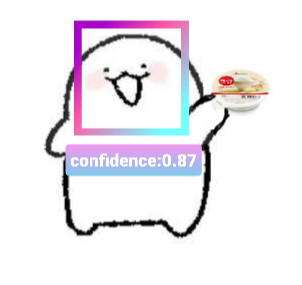
작성자:유성훈 


## Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn

dataset = pd.read_csv('churn_data.csv') # Users who were 60 days enrolled, churn in the next 30
dataset = dataset.drop(columns = ['app_web_user'])

# Data Preparation

In [2]:
user_identifier = dataset['user']
dataset = dataset.drop(columns = ['user'])

# Cleaning Data
dataset[dataset.credit_score < 300]
dataset = dataset[dataset.credit_score >= 300]

# Removing NaN
dataset.isna().any()
dataset.isna().sum()
dataset = dataset.drop(columns = ['credit_score', 'rewards_earned'])

##  One-Hot Encoding

In [3]:
dataset.housing.value_counts()
dataset.groupby('housing')['churn'].nunique().reset_index()
dataset = pd.get_dummies(dataset)
dataset.columns
dataset = dataset.drop(columns = ['housing_na', 'zodiac_sign_na', 'payment_type_na'])

## Splitting the dataset into the Training set and Test set

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset.drop(columns = 'churn'), dataset['churn'],
                                                    test_size = 0.2,
                                                    random_state = 0)

## Balancing the Training Set

In [5]:
import random

y_train.value_counts()

pos_index = y_train[y_train.values == 1].index
neg_index = y_train[y_train.values == 0].index

if len(pos_index) > len(neg_index):
    higher = pos_index
    lower = neg_index
else:
    higher = neg_index
    lower = pos_index

random.seed(0)
higher = np.random.choice(higher, size=len(lower))
lower = np.asarray(lower)
new_indexes = np.concatenate((lower, higher))

X_train = X_train.loc[new_indexes, ]
y_train = y_train[new_indexes]

## Feature Scaling

In [6]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train2 = pd.DataFrame(sc_X.fit_transform(X_train))
X_test2 = pd.DataFrame(sc_X.transform(X_test))
X_train2.columns = X_train.columns.values
X_test2.columns = X_test.columns.values
X_train2.index = X_train.index.values
X_test2.index = X_test.index.values
X_train = X_train2
X_test = X_test2

# Model Building

## Fitting Model to the Training Set

In [7]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

LogisticRegression(random_state=0)

##  Predicting Test Set

In [8]:
y_pred = classifier.predict(X_test)

## Evaluating Results

Test Data Accuracy: 0.6420


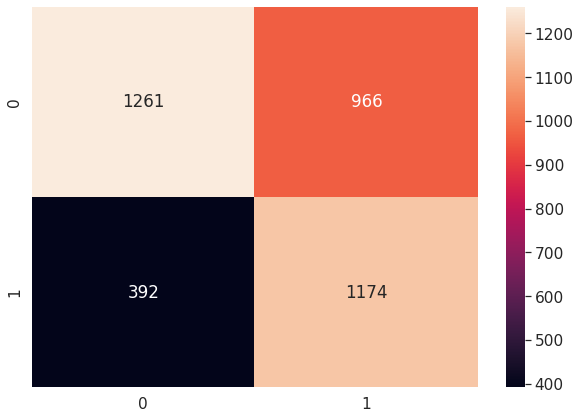

In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
cm = confusion_matrix(y_test, y_pred)
accuracy_score(y_test, y_pred)
precision_score(y_test, y_pred) # tp / (tp + fp)
recall_score(y_test, y_pred) # tp / (tp + fn)
f1_score(y_test, y_pred)

df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g')
print("Test Data Accuracy: %0.4f" % accuracy_score(y_test, y_pred))

# Applying k-Fold Cross Validation

In [10]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("SVM Accuracy: %0.3f (+/- %0.3f)" % (accuracies.mean(), accuracies.std() * 2))

SVM Accuracy: 0.651 (+/- 0.026)


##  Analyzing Coefficients

In [11]:
pd.concat([pd.DataFrame(X_train.columns, columns = ["features"]),
           pd.DataFrame(np.transpose(classifier.coef_), columns = ["coef"])
           ],axis = 1)

,features,coef
0,age,-0.185242
1,deposits,0.635281
2,withdrawal,0.019471
3,purchases_partners,-0.720045
4,purchases,-0.744754
5,cc_taken,0.056157
6,cc_recommended,0.012461
7,cc_disliked,-0.002265
8,cc_liked,0.033882
9,cc_application_begin,0.016940


# Feature Selection

## Recursive Feature Elimination

In [12]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

## Model to Test

## Select Best X Features

In [13]:
rfe = RFE(classifier, step = 20)

In [14]:
rfe = RFE(classifier, step = 20)
rfe = rfe.fit(X_train, y_train)

## summarize the selection of the attributes

In [15]:
print(rfe.support_)
print(rfe.ranking_)
X_train.columns[rfe.support_]

[ True  True False  True  True  True False False False False  True  True
  True  True  True False False  True  True False  True  True  True  True
 False  True False False  True False False  True False False False False
  True False False False False]
[1 1 3 1 1 1 3 3 3 3 1 1 1 1 1 3 3 1 1 3 1 1 1 1 3 1 3 2 1 3 3 1 3 3 3 3 1
 3 3 3 3]


Index(['age', 'deposits', 'purchases_partners', 'purchases', 'cc_taken',
       'app_downloaded', 'web_user', 'ios_user', 'android_user',
       'registered_phones', 'received_loan', 'rejected_loan',
       'left_for_one_month', 'reward_rate', 'is_referred', 'housing_O',
       'payment_type_Bi-Weekly', 'payment_type_Weekly', 'zodiac_sign_Cancer',
       'zodiac_sign_Pisces'],
      dtype='object')

## New Correlation Matrix

In [16]:
sn.set(style="white")

## Compute the correlation matrix

In [17]:
corr = X_train[X_train.columns[rfe.support_]].corr()

## Generate a mask for the upper triangle

In [18]:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


## Set up the matplotlib figure

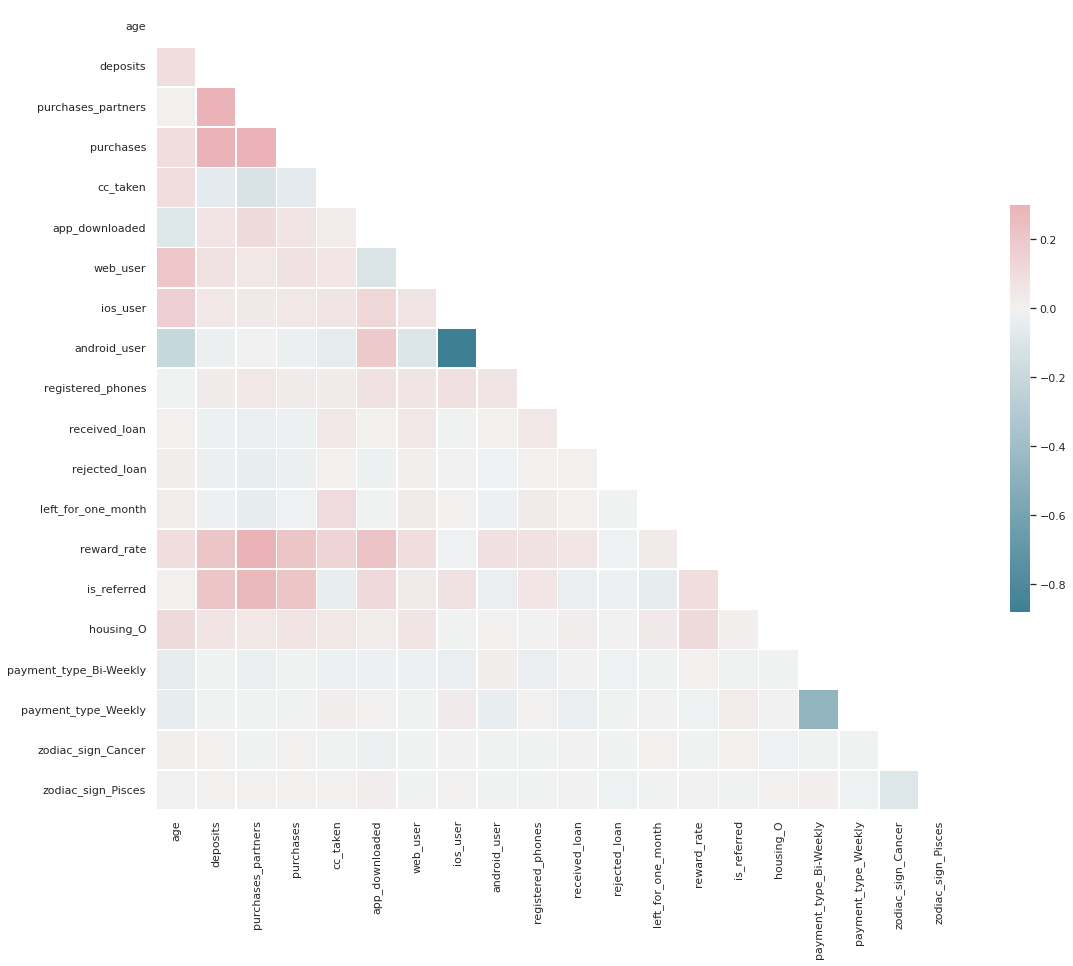

In [19]:
f, ax = plt.subplots(figsize=(18, 15))

# Generate a custom diverging colormap
cmap = sn.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sn.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})   

##  Fitting Model to the Training Set

In [20]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train[X_train.columns[rfe.support_]], y_train)

# Predicting Test Set
y_pred = classifier.predict(X_test[X_train.columns[rfe.support_]])

## Evaluating Results

Test Data Accuracy: 0.6428


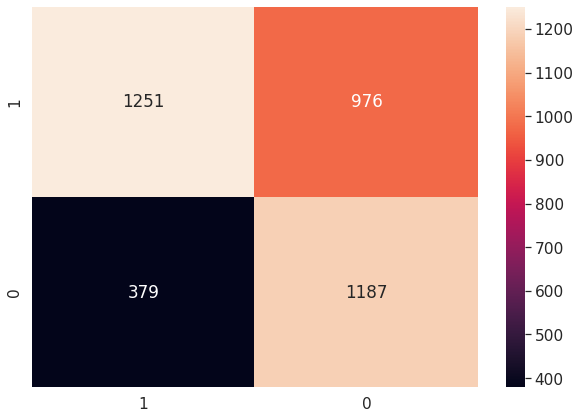

In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
cm = confusion_matrix(y_test, y_pred)
accuracy_score(y_test, y_pred)
precision_score(y_test, y_pred) # tp / (tp + fp)
recall_score(y_test, y_pred) # tp / (tp + fn)
f1_score(y_test, y_pred)

df_cm = pd.DataFrame(cm, index = (1, 0), columns = (1, 0))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g')
print("Test Data Accuracy: %0.4f" % accuracy_score(y_test, y_pred))


## Applying k-Fold Cross Validation

In [22]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier,
                             X = X_train[X_train.columns[rfe.support_]],
                             y = y_train, cv = 10)
print("SVM Accuracy: %0.3f (+/- %0.3f)" % (accuracies.mean(), accuracies.std() * 2))

SVM Accuracy: 0.653 (+/- 0.025)


## Analyzing Coefficients

In [23]:
pd.concat([pd.DataFrame(X_train[X_train.columns[rfe.support_]].columns, columns = ["features"]),
           pd.DataFrame(np.transpose(classifier.coef_), columns = ["coef"])
           ],axis = 1)

,features,coef
0,age,-0.186502
1,deposits,0.650774
2,purchases_partners,-0.709336
3,purchases,-0.740803
4,cc_taken,0.068119
5,app_downloaded,-0.056439
6,web_user,0.128503
7,ios_user,0.134461
8,android_user,0.037558
9,registered_phones,0.071971


## Formatting Final Results

In [24]:
final_results = pd.concat([y_test, user_identifier], axis = 1).dropna()
final_results['predicted_churn'] = y_pred
final_results = final_results[['user', 'churn', 'predicted_churn']].reset_index(drop=True)
